In [1]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import pandas as pd
train = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/test.csv')
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


- 데이터는 id, keyword, location, text, target 등 총 5개 변수로 이루어져 있습니다.
- id - 각 트위터 데이터의 식별자
- keyword - 해당 트윗의 특정 키워드
- location - 트위터가 작성된 장소
- text - 실제 트윗의 메시지
- target - 트위터가 실제로 재난이라면 1, 가짜라면 0으로 표시

In [3]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


- test 데이터에 target 변수 명이 없는 것을 확인할 수 있음

## 탐색적 자료 분석

<ipython-input-4-68b5ad668110>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


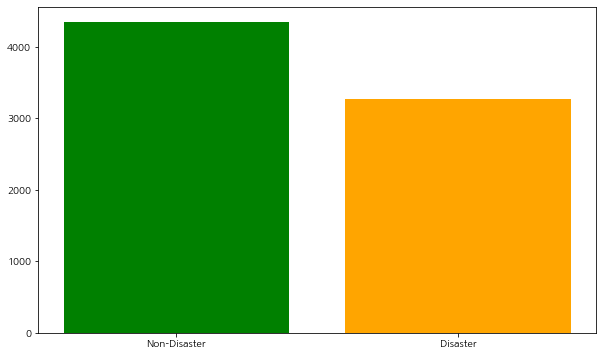

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
news_class = train['target'].value_counts()
labels = ['Non-Disaster', 'Disaster']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, news_class, color=['green', 'orange'])

fig.show()

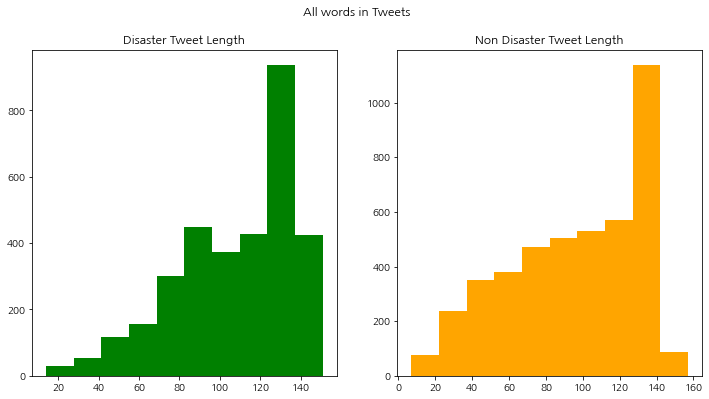

In [5]:
# 트윗 데이터 시각화
disaster_tweet_len = train[train['target']==1]['text'].str.len()
non_disaster_tweet_len = train[train['target']==0]['text'].str.len()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(disaster_tweet_len, color='green')
ax[0].set_title('Disaster Tweet Length')

ax[1].hist(non_disaster_tweet_len, color='orange')
ax[1].set_title('Non Disaster Tweet Length')

fig.suptitle('All words in Tweets')
plt.show()

- 길이가 140 이후 Non Disaster는 급격하게 떨어지는 것을 확인

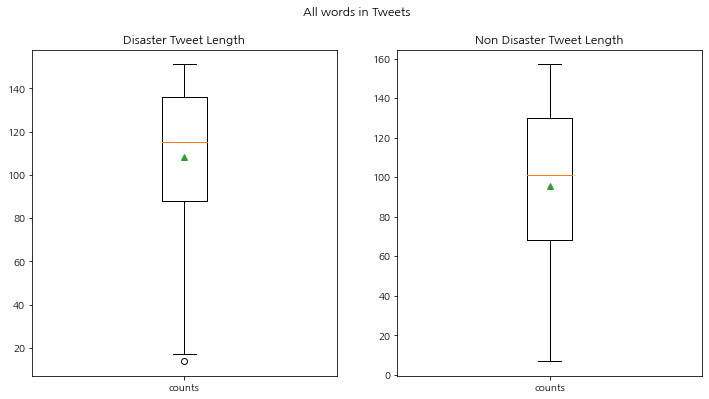

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].boxplot(disaster_tweet_len, labels=['counts'], showmeans=True)
ax[0].set_title('Disaster Tweet Length')

ax[1].boxplot(non_disaster_tweet_len, labels=['counts'], showmeans=True)
ax[1].set_title('Non Disaster Tweet Length')

fig.suptitle('All words in Tweets')
plt.show()


- 두 데이터 모두 중간값보다 작은 값을 나타내는 것을 확인할 수 있음

In [7]:
## Numpy 활용
import numpy as np

disaster_tweet_len = train[train['target']==1]['text'].str.len()
non_disaster_tweet_len = train[train['target']==0]['text'].str.len()

print('Max Length of Disaster Tweet: {}'.format(np.max(disaster_tweet_len)))
print('Min Length of Disaster Tweet: {}'.format(np.min(disaster_tweet_len)))
print('Mean Length of Disaster Tweet: {}'.format(np.mean(disaster_tweet_len)))
print('Median Length of Disaster Tweet: {}'.format(np.median(disaster_tweet_len)))

print('Max Length of Non Disaster Tweet: {}'.format(np.max(non_disaster_tweet_len)))
print('Min Length of Non Disaster Tweet: {}'.format(np.min(non_disaster_tweet_len)))
print('Mean Length of Non Disaster Tweet: {}'.format(np.mean(non_disaster_tweet_len)))
print('Median Length of Non Disaster Tweet: {}'.format(np.median(non_disaster_tweet_len)))

Max Length of Disaster Tweet: 151
Min Length of Disaster Tweet: 14
Mean Length of Disaster Tweet: 108.11342097217977
Median Length of Disaster Tweet: 115.0
Max Length of Non Disaster Tweet: 157
Min Length of Non Disaster Tweet: 7
Mean Length of Non Disaster Tweet: 95.70681713496084
Median Length of Non Disaster Tweet: 101.0


<ipython-input-8-cdc058eae20e>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


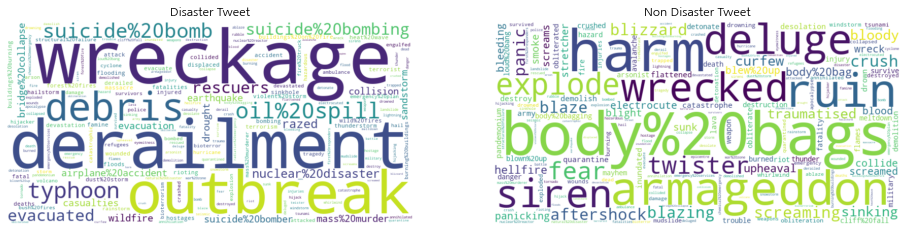

In [8]:
## wordcloud 활용
from wordcloud import WordCloud, STOPWORDS

disaster_tweet_keywords = dict(train[train['target']==1]['keyword'].value_counts())
non_disaster_tweet_keywords = dict(train[train['target']==0]['keyword'].value_counts())

stopwords=set(STOPWORDS)
disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
    generate_from_frequencies(disaster_tweet_keywords)

non_disaster_wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').\
    generate_from_frequencies(non_disaster_tweet_keywords)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweet')

ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non Disaster Tweet')

fig.show()

- Disaster 트윗은 Derailment(탈선), Outbreak(어떤 사건의 발생), Wreckage(난파), Typhoon(태풍) 등
     명사 하나로도 충분하게 설명되는 진짜 재난 뉴스인 반면
- Non Disaster 트윗은 명사보단 형용사나 동사가 주로 사용되는 것을 확인할 수 있음

## 피처 엔지니어링

In [9]:
# 결측치 확인
import pandas as pd
def check_na(data):
    isnull_na = (data.isnull().sum()/len(data))*100
    data_na = isnull_na.drop(isnull_na[isnull_na==0].index).sort_values(ascending=False)
    missing_data=pd.DataFrame({'Missing Ratio': data_na,
                                'Data Type': data.dtypes[data_na.index]})
    print('결측치 데이터 칼럼과 건수:\n', missing_data)

check_na(train)
check_na(test)

결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.272035    object
keyword        0.801261    object
결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.864542    object
keyword        0.796813    object


In [10]:
# test_id만 따로 추출해 저장
test_id = test['id']
for datas in [train, test]:
    datas = datas.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
    
train.shape, test.shape

((7613, 2), (3263, 1))

### Text Cleansing
- HTML 태그 제거
- 특수문자 공백으로 바꾸기
- 대문자 소문자로 바꾼 후, 리스트로 만들기
- 불용어 제거하기


In [11]:
# url 제거
import re


def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)


sample_text = "새로운 캐글 대회가 열렸습니다. 주소: https://www.kaggle.com/c/nlp-getting-started"
remove_url(sample_text)


'새로운 캐글 대회가 열렸습니다. 주소: '

In [12]:
# html 제거
def remove_html(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)


sample_text = """<div>
<h1> Real News or Fake News </h1>
<p> Kaggle Machine Learning </p>
</div>"""

print(remove_html(sample_text))



 Real News or Fake News 
 Kaggle Machine Learning 



In [13]:
!pip install emoji --upgrade

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169294 sha256=e85a9d4bc244d43f98967131b9c3ffa0a4f0eaca6ec95bc24d665a2649e00738
  Stored in directory: c:\users\wkddn\appdata\local\pip\cache\wheels\04\29\50\1e7189f03d2cf139e469863d54a1d3eabeb10c92c84e51f8a1
Successfully built emoji


In [14]:
import emoji
print(emoji.emojize('Phd is very easy!!! :thumbs_up:'))


Phd is very easy!!! 👍


In [15]:
def remove_emoji(text):
  emoji_pattern = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)


remove_emoji("Hello, 👍")


'Hello, '

In [16]:
def remove_punct(text):
  return re.sub("[^a-zA-Z]", " ", text)


sample_text = "Hello!, Can I have one question?.., Is it #Outbreak?"
remove_punct(sample_text)


'Hello   Can I have one question     Is it  Outbreak '

In [17]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

print("Total Length of stopwords:", len(stopwords.words('english')))
print(stopwords.words('english')[:10])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wkddn\AppData\Roaming\nltk_data...


Total Length of stopwords: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data]   Unzipping corpora\stopwords.zip.


In [18]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def data_cleansing(text, remove_stopwords = False):
  # remove url 
  url = re.compile(r'https?://\S+|www\.\S+')
  cleaned_text = url.sub(r'', text)

  # remove html
  html = re.compile(r'<.*?>')
  cleaned_text = html.sub(r'', cleaned_text)

  # remove emoji
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  cleaned_text = emoji_pattern.sub(r'', cleaned_text)

  # Special Letters to empty space
  cleaned_text = re.sub("[^a-zA-Z]", " ", cleaned_text)

  # Lowercase
  cleaned_text = cleaned_text.lower().split()

  if remove_stopwords:
    stops = set(stopwords.words("english"))
    cleaned_text = [word for word in cleaned_text if not word in stops]
    clean_review = ' '.join(cleaned_text)
  else:
    clean_review = ' '.join(cleaned_text)

  return clean_review

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wkddn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
clean_train_reviews = []
for datas in [train, test]:
    datas['cleaned_text'] = datas['text'].apply(
        lambda x: data_cleansing(x, remove_stopwords=True))

train.head(5)


,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [20]:
test.head(5)

,text,cleaned_text
0,Just happened a terrible car crash,happened terrible car crash
1,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan
